In [1]:
!pip install hazm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 22.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 91.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 88.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=75c2fa15fb08c9ef8d9f3434252f69ff01e93421f47702a45a350452fd109248
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uni

In [2]:
import pandas as pd
import re
from hazm import Normalizer, stopwords_list, word_tokenize
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
df = pd.read_csv("/kaggle/input/persian-spam-email/emails.csv")

In [5]:
df.shape

(1000, 2)

In [6]:
df.head()

,text,label
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham


In [7]:
print("\nLabel Distribution:")
print(df['label'].value_counts())


Label Distribution:
label
ham     500
spam    500
Name: count, dtype: int64


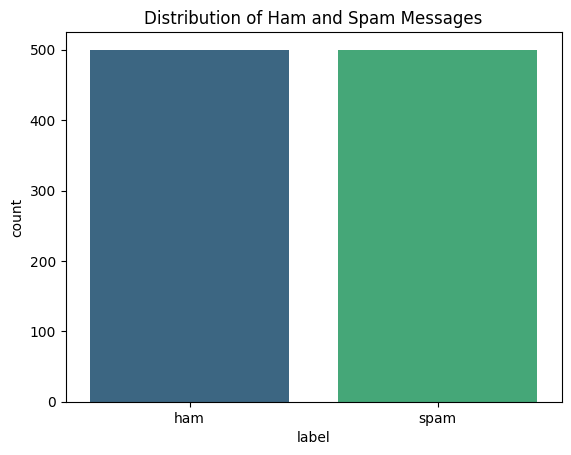

In [8]:
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Distribution of Ham and Spam Messages")
plt.show()

In [9]:
normalizer = Normalizer()
stopwords = set(stopwords_list())

In [10]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    
    # Remove phone numbers (any sequence of 7+ digits)
    text = re.sub(r'\b\d{7,}\b', '', text)
    
    # Reduce repeated characters (e.g., ععععلی → علی)
    text = re.sub(r'(\w)\1{2,}', r'\1', text)

    # Remove usernames
    text = re.sub(r'@[^ ]+', '', text)

    # Remove htmls
    text = re.sub(re.compile('<.*?>') , '', text)

    # Remove hashtags
    text = re.sub(r'#', '', text)

    # Normalize text
    text = normalizer.normalize(text)
    
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    # Remove empty tokens
    tokens = [word for word in tokens if word.strip() != '']
    return ' '.join(tokens)

In [11]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [12]:
df.head()

,text,label,cleaned_text
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham,﻿ممنون آقا سامان . پارسال اصلا آزاد شرکت نکرده...
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham,﻿سلام کریمی بالاخره آزمونارشد تموم راحت شدم یک...
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham,﻿درود حاج وحیدی بنده بعنوان دکتری تاریخ دستی ت...
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham,﻿با سلام احترام تقدیر مسولین محترم سایت تابناک...
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham,﻿با سلام اینجانب دستگاه خودرو پراید ۱۳۱ شماره ...


In [13]:
PBert_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
PBert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

In [14]:
def tokenize_text(tokenizer, text, max_length=32):
    tokens = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return tokens

def get_embeddings(text, max_length=32):
    tokens = tokenize_text(PBert_tokenizer, text, max_length)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    with torch.no_grad():
        outputs = PBert_model(input_ids, attention_mask=attention_mask)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0).cpu().numpy()

In [15]:
df['embeddings'] = df['cleaned_text'].apply(get_embeddings)

embeddings = df['embeddings'].tolist()
pca = PCA(n_components=120)
reduced_embeddings = pca.fit_transform(embeddings)

df['reduced_embeddings'] = list(reduced_embeddings)

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [16]:
df.to_csv("preprocessed_data.csv")

In [17]:
df = pd.read_csv("/kaggle/working/preprocessed_data.csv")

In [18]:
df.head()

,Unnamed: 0,text,label,cleaned_text,embeddings,reduced_embeddings
0,0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham,﻿ممنون آقا سامان . پارسال اصلا آزاد شرکت نکرده...,[ 2.03596130e-01 -6.73360646e-01 1.99428499e+...,[ 1.25913998e+01 -1.92047112e+00 -2.15438638e-...
1,1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham,﻿سلام کریمی بالاخره آزمونارشد تموم راحت شدم یک...,[ 4.62497562e-01 6.67644739e-01 1.88398123e+...,[ 6.89361545e+00 1.48506949e+00 -2.04357494e+...
2,2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham,﻿درود حاج وحیدی بنده بعنوان دکتری تاریخ دستی ت...,[ 6.09418869e-01 -2.64802396e-01 1.13385665e+...,[ 9.18436277e-01 7.45215921e+00 -1.50741209e+...
3,3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham,﻿با سلام احترام تقدیر مسولین محترم سایت تابناک...,[ 1.05735135e+00 -4.83997107e-01 1.77630186e+...,[-0.38771439 11.45605778 -4.08703325 -0.365284...
4,4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham,﻿با سلام اینجانب دستگاه خودرو پراید ۱۳۱ شماره ...,[ 3.84518057e-01 -2.04942912e-01 1.79146230e+...,[ 3.99238182 4.21717633 -1.61648332 -2.775611...


In [19]:
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

In [20]:
print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Label Mapping: {'ham': 0, 'spam': 1}


In [21]:
X = torch.tensor(reduced_embeddings, dtype=torch.float32)
y = torch.tensor(df['encoded_label'].values, dtype=torch.long)

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [23]:
print(f"x_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"x_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")

print(f"x_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

x_train: torch.Size([560, 120])
y_train: torch.Size([560])
x_val:   torch.Size([140, 120])
y_val:   torch.Size([140])
x_test:  torch.Size([300, 120])
y_test:  torch.Size([300])


In [35]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        conv_output_dim = input_dim // 2

        self.fc_cnn = nn.Linear(64 * conv_output_dim, input_dim)

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=128, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = x.view(x.size(0), -1)
        x = self.fc_cnn(x)

        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim, num_classes, num_filters=64, kernel_size=3, pool_size=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=pool_size)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear((input_dim // pool_size) * num_filters, 128)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [26]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, bidirectional=False):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = hidden[-1]
        out = self.fc(hidden)
        x = self.sigmoid(x)
        return out

In [27]:
def train_model(train_loader, val_loader, model, batch_size, lr, optimizer_choice, num_epochs=50):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_choice(model.parameters(), lr=lr)

    best_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if isinstance(model, SimpleLSTM):
                inputs = inputs.view(inputs.size(0), -1, inputs.size(1))
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                if isinstance(model, SimpleLSTM):
                    inputs = inputs.view(inputs.size(0), -1, inputs.size(1))
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.append(preds)
                val_true.append(labels)

        val_preds = torch.cat(val_preds).cpu().numpy()
        val_true = torch.cat(val_true).cpu().numpy()
        val_acc = accuracy_score(val_true, val_preds)
        # print(f"    Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            best_model_state = model.state_dict()
    
    return best_model_state


def evaluate_model(model, test_loader):
    model = model.to(device)
    model.eval()
    y_true, y_preds = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if isinstance(model, SimpleLSTM):
                inputs = inputs.view(inputs.size(0), -1, inputs.size(1))
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_preds.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    
    # report = classification_report(y_true, y_preds, zero_division=0)
    acc = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='macro', zero_division=0)
    recall = recall_score(y_true, y_preds, average='macro')
    f1 = f1_score(y_true, y_preds, average='macro')
    roc_auc = roc_auc_score(y_true, y_preds)
    
    metrics_data = {
        "Accuracy": [acc],
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1],
        "ROC AUC": [roc_auc]
    }
    metrics_df = pd.DataFrame(metrics_data)

    print(metrics_df)
    print()
    
    return metrics_df


In [28]:
train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor = torch.utils.data.TensorDataset(X_test, y_test)

In [29]:
batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = [optim.Adam, optim.SGD]

In [30]:
best_model_state = None
best_f1 = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_tensor, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=batch_size)
    for lr in learning_rates:
        for opt in optimizers:
            print(f"Training Simple LSTM with Batch={batch_size}, LR={lr}, Optimizer={opt.__name__}")
            model = SimpleLSTM(input_dim=120, hidden_dim=64, num_classes=len(y.unique()))
            model_state = train_model(train_loader, val_loader, model, batch_size, lr, opt)
            model.load_state_dict(model_state)
            print("\nEvaluating Simple LSTM on Test Data...")
            SimpleLSTM_results = evaluate_model(model, test_loader)
            if SimpleLSTM_results['F1-Score'].iloc[0] > best_f1:
                best_model_state = model.state_dict()
                best_f1 = SimpleLSTM_results['F1-Score'].iloc[0]
                best_hyperparams = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'optimizer': opt.__name__,
                }

Training Simple LSTM with Batch=8, LR=0.001, Optimizer=Adam

Evaluating Simple LSTM on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.966667    0.96675  0.966667  0.966665  0.966667

Training Simple LSTM with Batch=8, LR=0.001, Optimizer=SGD

Evaluating Simple LSTM on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.903333   0.905514  0.903333  0.903203  0.903333

Training Simple LSTM with Batch=8, LR=0.0001, Optimizer=Adam

Evaluating Simple LSTM on Test Data...
   Accuracy  Precision  Recall  F1-Score  ROC AUC
0      0.96       0.96    0.96      0.96     0.96

Training Simple LSTM with Batch=8, LR=0.0001, Optimizer=SGD

Evaluating Simple LSTM on Test Data...
   Accuracy  Precision  Recall  F1-Score  ROC AUC
0      0.72   0.795982    0.72  0.700798     0.72

Training Simple LSTM with Batch=64, LR=0.001, Optimizer=Adam

Evaluating Simple LSTM on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.963333   0.963354  0.9633

In [31]:
best_model = SimpleLSTM(input_dim=120, hidden_dim=64, num_classes=len(y.unique())).to(device)
best_model.load_state_dict(best_model_state)
_ = evaluate_model(best_model, test_loader)

print("\nBest Hyperparameters:")
print(f"    Batch Size: {best_hyperparams['batch_size']}")
print(f"    Learning Rate: {best_hyperparams['learning_rate']}")
print(f"    Optimizer: {best_hyperparams['optimizer']}")
print(f"Best F1 Score: {best_f1:.4f}")

   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.966667    0.96675  0.966667  0.966665  0.966667


Best Hyperparameters:
    Batch Size: 8
    Learning Rate: 0.001
    Optimizer: Adam
Best F1 Score: 0.9667


In [32]:
best_model_state = None
best_f1 = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_tensor, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=batch_size)
    for lr in learning_rates:
        for opt in optimizers:
            print(f"Training CNN with Batch={batch_size}, LR={lr}, Optimizer={opt.__name__}")
            model = SimpleCNN(input_dim=120, num_classes=len(torch.unique(y_train)))
            model_state = train_model(train_loader, val_loader, model, batch_size, lr, opt)
            model.load_state_dict(model_state)
            print("\nEvaluating CNN on Test Data...")
            SimpleCNN_results = evaluate_model(model, test_loader)
            if SimpleCNN_results['F1-Score'].iloc[0] > best_f1:
                best_model_state = model.state_dict()
                best_f1 = SimpleCNN_results['F1-Score'].iloc[0]
                best_hyperparams = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'optimizer': opt.__name__,
                }

Training CNN with Batch=8, LR=0.001, Optimizer=Adam

Evaluating CNN on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.953333   0.953656  0.953333  0.953325  0.953333

Training CNN with Batch=8, LR=0.001, Optimizer=SGD

Evaluating CNN on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.933333   0.934028  0.933333  0.933307  0.933333

Training CNN with Batch=8, LR=0.0001, Optimizer=Adam

Evaluating CNN on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.973333   0.973417  0.973333  0.973332  0.973333

Training CNN with Batch=8, LR=0.0001, Optimizer=SGD

Evaluating CNN on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.906667    0.91024  0.906667  0.906463  0.906667

Training CNN with Batch=64, LR=0.001, Optimizer=Adam

Evaluating CNN on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.973333   0.973417  0.973333  0.973332  0.973333

Training CNN with Batch=64, LR=0.001, Optimi

In [33]:
best_model = SimpleCNN(input_dim=120, num_classes=len(y.unique())).to(device)
best_model.load_state_dict(best_model_state)
_ = evaluate_model(best_model, test_loader)

print("\nBest Hyperparameters:")
print(f"    Batch Size: {best_hyperparams['batch_size']}")
print(f"    Learning Rate: {best_hyperparams['learning_rate']}")
print(f"    Optimizer: {best_hyperparams['optimizer']}")
print(f"Best F1 Score: {best_f1:.4f}")

   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.976667   0.976857  0.976667  0.976664  0.976667


Best Hyperparameters:
    Batch Size: 64
    Learning Rate: 0.0001
    Optimizer: Adam
Best F1 Score: 0.9767


In [36]:
best_model_state = None
best_f1 = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_tensor, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=batch_size)
    for lr in learning_rates:
        for opt in optimizers:
            print(f"Training CNN-LSTM with Batch={batch_size}, LR={lr}, Optimizer={opt.__name__}")
            model = CNNLSTM(input_dim=X_train.shape[1], num_classes=len(torch.unique(y_train)))
            model_state = train_model(train_loader, val_loader, model, batch_size, lr, opt)
            model.load_state_dict(model_state)
            print("\n    Evaluating CNN-LSTM on Test Data...")
            CNNLSTM_results = evaluate_model(model, test_loader)
            if CNNLSTM_results['F1-Score'].iloc[0] > best_f1:
                best_model_state = model.state_dict()
                best_f1 = CNNLSTM_results['F1-Score'].iloc[0]
                best_hyperparams = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'optimizer': opt.__name__,
                }

Training CNN-LSTM with Batch=8, LR=0.001, Optimizer=Adam

    Evaluating CNN-LSTM on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.946667   0.947382  0.946667  0.946645  0.946667

Training CNN-LSTM with Batch=8, LR=0.001, Optimizer=SGD

    Evaluating CNN-LSTM on Test Data...
   Accuracy  Precision  Recall  F1-Score  ROC AUC
0       0.5       0.25     0.5  0.333333      0.5

Training CNN-LSTM with Batch=8, LR=0.0001, Optimizer=Adam

    Evaluating CNN-LSTM on Test Data...
   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.956667   0.956849  0.956667  0.956662  0.956667

Training CNN-LSTM with Batch=8, LR=0.0001, Optimizer=SGD

    Evaluating CNN-LSTM on Test Data...
   Accuracy  Precision  Recall  F1-Score  ROC AUC
0       0.5       0.25     0.5  0.333333      0.5

Training CNN-LSTM with Batch=64, LR=0.001, Optimizer=Adam

    Evaluating CNN-LSTM on Test Data...
   Accuracy  Precision  Recall  F1-Score  ROC AUC
0      0.96   0.960082    0.96  0.959998   

In [37]:
best_model = CNNLSTM(input_dim=X_train.shape[1], num_classes=len(torch.unique(y_train)))
best_model.load_state_dict(best_model_state)
_ = evaluate_model(best_model, test_loader)

print("\nBest Hyperparameters:")
print(f"    Batch Size: {best_hyperparams['batch_size']}")
print(f"    Learning Rate: {best_hyperparams['learning_rate']}")
print(f"    Optimizer: {best_hyperparams['optimizer']}")
print(f"Best F1 Score: {best_f1:.4f}")

   Accuracy  Precision    Recall  F1-Score   ROC AUC
0  0.966667   0.966667  0.966667  0.966667  0.966667


Best Hyperparameters:
    Batch Size: 64
    Learning Rate: 0.0001
    Optimizer: Adam
Best F1 Score: 0.9667


In [38]:
vectorizer = CountVectorizer(max_features=120)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
models = {
    "Support Vector Machine": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Multinomial Naive Bayes": MultinomialNB()
}

In [40]:
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    
    results.append([model_name, acc, precision, recall, f1, roc_auc])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])
print(df_results)

                     Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0   Support Vector Machine  0.896667   0.901828  0.896667  0.896334  0.974489
1      Logistic Regression  0.943333   0.943511  0.943333  0.943328  0.981022
2            Random Forest  0.930000   0.930478  0.930000  0.929981  0.983889
3  Multinomial Naive Bayes  0.936667   0.936841  0.936667  0.936660  0.980000
